# Определение авторства статьи на основе нейронных сетей
### Постановка задачи:
* ......
* ......

**Распоковка датасета**

In [1]:
!unzip -u dataset.zip
print('Success')

Archive:  dataset.zip
Success


In [2]:
!zip -r datasetCSV.zip datasetHabrahabr.csv

  adding: datasetHabrahabr.csv (deflated 76%)


**Импорт пакетов**

In [148]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import keras
import codecs
import os

%matplotlib inline

**Загрузка готового набора данных**

In [2]:
data = pd.read_csv('datasetHabrahabr.csv')
data.head()

,Author,Text,TextLem
0,25,"В шестой части серии учебных материалов, посв...","в шесть часть серия учебный материалов, посвят..."
1,25,С каждым новом поколением процессоры Intel вб...,с каждый новый поколение процессор intel вбира...
2,25,Статья в блоге Intel «Прокачай свой жесткий д...,статья в блог intel «прокачать свой жёсткий ди...
3,25,Испанская компания с говорящим названием Geek...,испанский компания с говорящий название geeksp...
4,25,igzip — высокопроизводительная библиотека для...,igzip — высокопроизводительный библиотека для ...


**Загрузка тестовых документов**

In [3]:
def get_dataset_from_files():
    #path = 'D:\Разработка\DataScience\Habrahabr'
    path = 'Habrahabr/'
    files = os.listdir(path)
    data_frame = pd.DataFrame()

    for file_name in files:
        file_obj = codecs.open(path + file_name, "r", "utf_8_sig" )
        file_temp = file_obj.read()
        url = file_temp[file_temp.find('url:') + 5:file_temp.find('title:')].rstrip()
        title = file_temp[file_temp.find('title:') + 7:file_temp.find('text:')].rstrip()
        text = file_temp[file_temp.find('text:') + 5:file_temp.find('author:')].rstrip()
        author = file_temp[file_temp.find('author:') + 8:].rstrip()
        row = pd.Series([url, title, text, author], index=['Url', 'Title', 'Text', 'Author'])
        data_frame = data_frame.append(row, ignore_index=True)
        file_obj.close()
        
    return data_frame

In [4]:
#data = get_dataset_from_files()

**Подсчет количества слов в каждой статье**

In [5]:
data['CountWords'] = data['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data))
data.head()

Количество статей в корпусе: 3381


,Author,Text,TextLem,CountWords
0,25,"В шестой части серии учебных материалов, посв...","в шесть часть серия учебный материалов, посвят...",2260
1,25,С каждым новом поколением процессоры Intel вб...,с каждый новый поколение процессор intel вбира...,756
2,25,Статья в блоге Intel «Прокачай свой жесткий д...,статья в блог intel «прокачать свой жёсткий ди...,795
3,25,Испанская компания с говорящим названием Geek...,испанский компания с говорящий название geeksp...,107
4,25,igzip — высокопроизводительная библиотека для...,igzip — высокопроизводительный библиотека для ...,1534


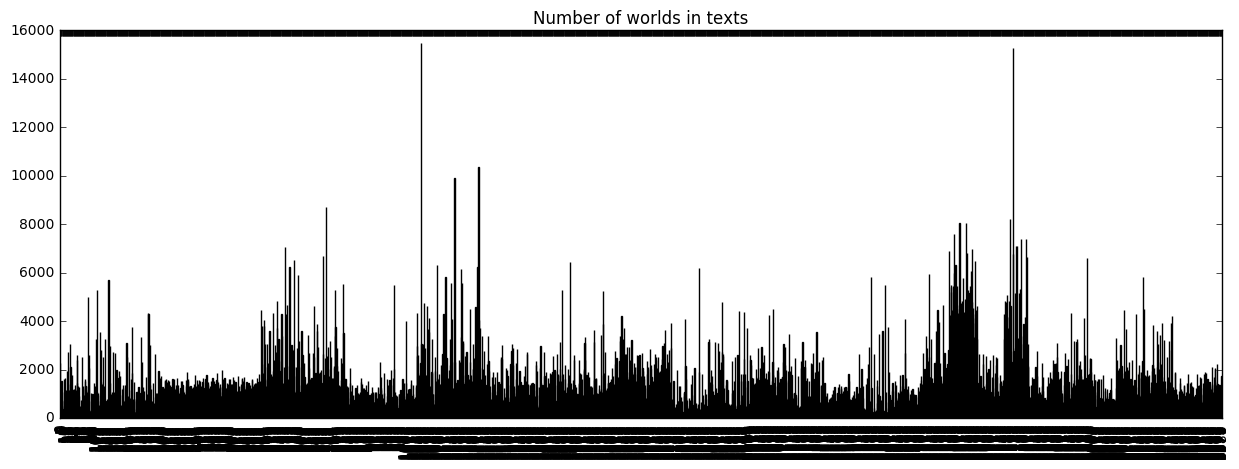

In [6]:
data.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts");

**Количество статей у каждого пользователя**

In [26]:
num_classes = 29

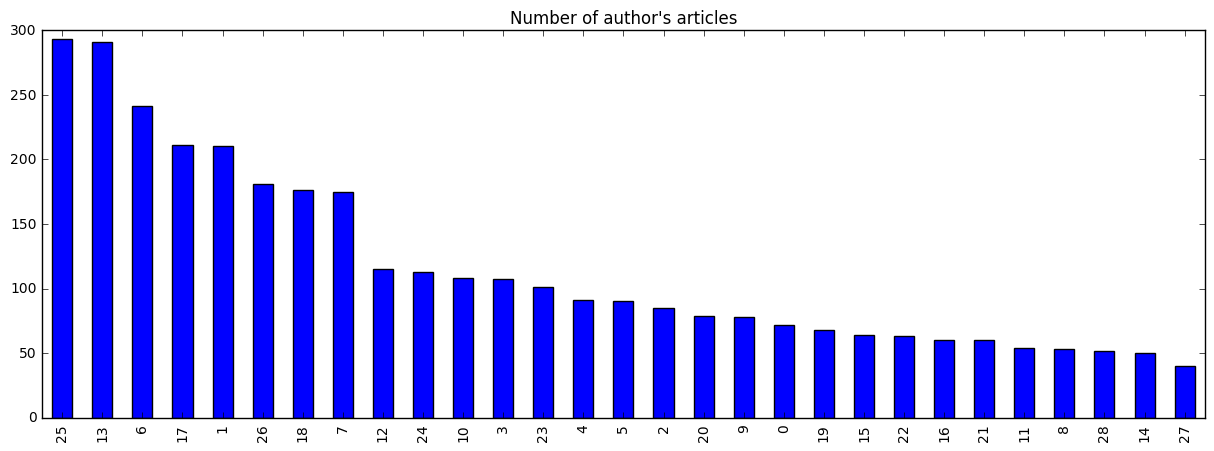

In [8]:
author_count_news = data.Author.value_counts()[:num_classes]
author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles");

### Подготовка данных для анализа
- Добавление только топ 30 авторов
- Удаление стоп слов
- Лемматизация текста
- Удаление лишних столбцов
- One hot encoding для авторов

In [9]:
temp_data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    temp_data = temp_data.append(data[data.Author == author])

data = temp_data
print('Количество статей после удаления:', len(data))

Количество статей после удаления: 3381


In [20]:
from nltk.corpus import stopwords
stop = stopwords.words('russian')
data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
print('Stop words have been deleted')

Stop words have been deleted


In [22]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
print('The lemmatization completed')

The lemmatization completed


In [10]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

#lableEnc.fit(names_author.ravel()) 
#lables = lableEnc.transform(names_author).reshape((num_classes, 1))
#oneHotEnc.fit(lables)

# Example encoding
#aaa = lableEnc.transform(['@saul'])
#vvv = oneHotEnc.transform(aaa).toarray()
#print(vvv)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [11]:
for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

#data = data.drop(['Url', 'Title', 'CountWords'], axis=1)
data.head()

,Author,Text,TextLem,CountWords
0,25,"В шестой части серии учебных материалов, посв...","в шесть часть серия учебный материалов, посвят...",2260
1,25,С каждым новом поколением процессоры Intel вб...,с каждый новый поколение процессор intel вбира...,756
2,25,Статья в блоге Intel «Прокачай свой жесткий д...,статья в блог intel «прокачать свой жёсткий ди...,795
3,25,Испанская компания с говорящим названием Geek...,испанский компания с говорящий название geeksp...,107
4,25,igzip — высокопроизводительная библиотека для...,igzip — высокопроизводительный библиотека для ...,1534


**Сохранение датасета**

In [28]:
filename = 'datasetHabrahabr.csv'
data.to_csv(filename, index=False, encoding='utf-8')

**Перемешивание набора данных**

In [3]:
data = data.sample(frac=1).reset_index(drop=True)

**Токенизация текста**

In [138]:
def get_texts_to_matrix(texts, max_features = 0):
    tokenizer = Tokenizer(split=" ", lower=True)
    if max_features != 0:
        tokenizer = Tokenizer(split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(texts)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [139]:
def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    print('В словаре {} слов'.format(len(tokenizer.word_index)))
    return text_sequences

In [140]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    gramms = {}
    counter_gramm = 0
    result = []
    temp_vector = []
    
    for text in texts:
        for i in range(len(text) - count_gramm - 1):
            gramm = text[i : i + count_gramm]
            if gramms.get(gramm) == None:
                gramms[gramm] = counter_gramm
                counter_gramm += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
        temp_vector = []
        
    print('Количество грамм в корпусе:', len(gramms))
    #count_gramm = [len(x) for x in text_threegramm]
    #num = np.array(count_gramm)
    #num.mean()
    return result

In [141]:
#X = get_texts_to_matrix(data['Text'])
#X = get_texts_to_gramm_sequences(data['Text'])
X = get_texts_to_sequences(data['Text'])

В словаре 270878 слов


### Разбиваем выборку на тестовую и тренировочную

In [142]:
def get_X_y_for_traning(X, y, num_words):
    #tokenizer = Tokenizer(num_words=num_words)
    #X = tokenizer.sequences_to_matrix(X_train, mode='binary')
    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=num_words) 
    y = keras.utils.to_categorical(y, num_classes)
    print('Размерность X:', X.shape) 
    print('Размерность y:', y.shape)
    return X, y

In [143]:
# Максимальное количество слов в самом длинном тексте
num_words = 5000
X_full, y_full = get_X_y_for_traning(X, data.Author, num_words)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=0)

print('Testing set size:', len(X_test))
print('Training set size:', len(X_train))

Размерность X: (3381, 5000)
Размерность y: (3381, 29)
Testing set size: 677
Training set size: 2704


### Создание модели нейронной сети

In [144]:
def get_lstm_model():
    max_features = 100000
    model = Sequential()
    # Слой для векторного представления слов
    model.add(Embedding(max_features, 500))
    model.add(SpatialDropout1D(0.3))
    # Слой долго-краткосрочной памяти
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) 
    # Полносвязный слой
    model.add(Dense(num_classes, activation="sigmoid"))
    # Копмилируем модель
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_model(input_length):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_lstm_model(input_length):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)) 
    #model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = get_conv_model(input_length = num_words)
model.summary()

BATCH_SIZE = 64
EPOCHS = 9

history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2, 
                    validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 5000, 300)         6000000   
_________________________________________________________________
spatial_dropout1d_31 (Spatia (None, 5000, 300)         0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 4998, 512)         461312    
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 29)                14877     
Total params: 6,476,189
Trainable params: 6,476,189
Non-trainable params: 0
_________________________________________________________________
Train on 2433 samples, validate on 271 samples
Epoch 1/9
29s - loss: 3.2236 - acc: 0.1644 - val_loss: 3.1323 - val_acc: 0.1328
Epoch

In [150]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=32, verbose=2)[1] * 100))

Точность модели составляет: 2.806499261447563


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


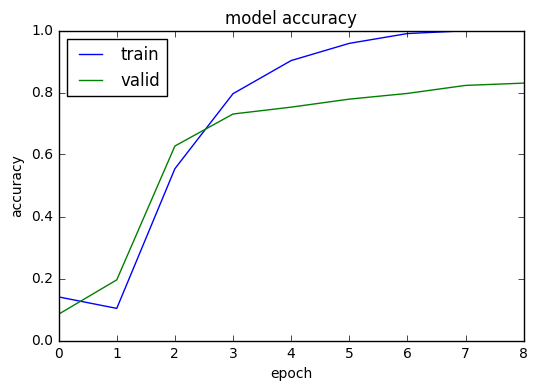

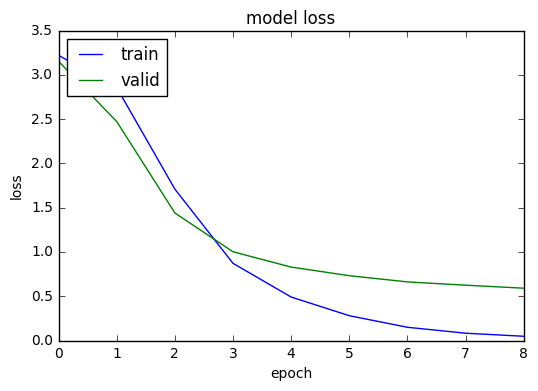

In [147]:
from matplotlib import pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show();

In [99]:
def save_model(model_name):
    # Генерируем описание модели в формате json
    model_json = model.to_json(model_name)
    # Записываем модель в файл
    json_file = open("model/{}_model.json".Format(model_name), "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights("model/{}_weights.h5".Format(model_name))

In [100]:
#save_model(habra_86persent)